In [2]:
# Previously we analyzed reanalysis data. Reanalysis data is the closest thing to real life. Reanalysis models assimilate observational data to 
# calculate the state of the atmosphere at given points of time in real life. 

# One issue with reanalysis, however, is that it can only tell us about what's gone on in the past. It obviously can't tell us what the weather will be like in the future.
# To get a sense of what the weather wil be like in the future, we need the help of a General Circulation Model (GCM). GCMs simulate the behavior of the atmosphere, 
# and sometimes other parts of the earth system depending on how complex the GCM is.

# GFDL is one of the inventors of GCMs. These days, one of our flagship models is AM4, which is an atmosphere-only model. In the following experimental data, AM4 is ran with
# prescribed sea surface temperatures (SST) climatology of a historical period (1980-2014). This experiment is useful because we can later compare it to a simulation that 
# represents a scenario from the year 2065-2099 where greenhouse gases are allowed to increase unabated 

# Let's look at heat extremes in the same region and see how AM4 compares to reanalysis 


# load in the necessary libraries
import scipy.io as scp
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import datetime as dt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#Initialization Parameters
#############
locname='NYC' #name of location of focus
runname='CTL_V2' #name of model run being examined
lonwant=360-74 # NY is 74 West longitude, but the longitude dimension goes from 0 to 360, so we do 360-74
latwant=40.71
directoryt = '/work/Veeshan.Narinesingh/EXTREME_HEAT_EVENTS_TdT_ANALYSIS/' + runname + '/ATMOS_LEVEL/DAILY/' #directory for temp, psl, and zg data

savename=locname + '_hwstardates_and_durations_' + runname + '.nc' #what to call the heatwave file you save
filename = 'atmos_level.*.temp.0998SigmahPa.daily.nc'


#load in the temperature data; note for ERA5 we looked at 41 years of data, for AM4 we will look at a 50 year simulation 
ds = xr.open_mfdataset(directoryt + filename) 
var1 = ds.temp
lat = ds.lat
lon = ds.lon
time = ds.time
varloc = var1.sel(lat=latwant,lon=lonwant,method='nearest') 

In [3]:

#climatology and anomaly calculation


var1smooth5=varloc.rolling(time=5,center=True,min_periods=1).mean()#5 day smooth using running mean
# turn into array and reshape to be 50 years by 365 days
var1smooth5np=var1smooth5.values.reshape((50,365))
#now turn back into xarray because python is unnecessarily complicated for some things
var1smooth5rs= xr.DataArray(data=var1smooth5np,dims=["year","day"],coords=dict(year=np.arange(2,52,1),day=np.arange(1,366,1)))
var1smooth5rs15day1=var1smooth5rs.rolling(day=15,center=True,min_periods=1).mean()#1st 15 day running mean 
var1smooth5rs15day2=var1smooth5rs15day1.rolling(day=15,center=True,min_periods=1).mean()#2nd 15 day running mean 
clim=var1smooth5rs15day2.rolling(year=11,center=True,min_periods=1).mean()#29 day by 11 year climatology
anom=var1smooth5rs-clim

#find 90th percentile for summer heat
anomjja=anom[:,150:242] #june 1st is idx 150 day of the year, Aug 31 is idx 241
thresh90=np.percentile((anomjja),90)

#get hw dates at location 
timers=time.values.reshape((50,365))
timersjja=timers[:,150:242] 

anomjjamat=anomjja.values

hwidcs=np.where(anomjjamat>thresh90)


hwdates=timersjja[hwidcs]

#find start dates
test = 2.0 * hwdates / hwdates
test[1:] = np.diff(hwdates)
independent_events = np.where(test != 1.0, 1.0, 0.0)
event_indices = independent_events * hwdates
event_startdates = event_indices[event_indices != 0].astype('int')

hwdatesint=hwdates.astype(int)
bimat = np.zeros(int(max(hwdates)))
for id in hwdatesint:
    bimat[int(id-1)]=1
    
from scipy.ndimage import label
labels, num_components = label(bimat)
print("Labels:")
print(labels)
print("Number of components:", num_components)

# Calculate the size of each label
label_sizes = np.bincount(labels.ravel())

durations=label_sizes[1:]       

#save start dates and durations
event_startdates_xr = xr.DataArray(data=event_startdates).rename('event_startdates')
durations_xr = xr.DataArray(data=durations).rename('event_duration')

# Create xarray Dataset
dataset = xr.Dataset(
    {
        "event_startdates": event_startdates_xr,
        "event_durations": durations_xr,
    }
)

dataset.to_netcdf(savename)


Labels:
[  0   0   0 ...   0   0 133]
Number of components: 133


Average Duration: 3.4586466165413534 days


Text(0, 0.5, 'Count')

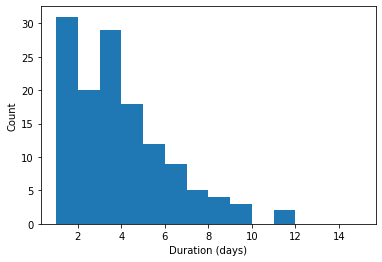

In [4]:
# let's plot the duration histogram again

#Calculate the average heat extreme duration and make a histogram
print('Average Duration: ' + str(durations.mean()) + ' days')

plt.hist(durations,bins=list(range(1, 16))) #bins=list(range(1, 16)) produces histogram bins that go to 1 to 15
plt.xlabel('Duration (days)')
plt.ylabel('Count')

In [7]:
# Going forward let's just focus on the longest lasting events by picking the top half of the data
hwdatesfilexr = xr.open_dataset(savename) 
startdates = hwdatesfilexr.event_startdates
durations = hwdatesfilexr.event_durations
numevents=len(durations)
tophowmany=numevents // 2 # this divides a number by two and rounds down


# get indices for top events only
durationssortidx=np.argsort(-durations)
durationssort=durations[durationssortidx]


print('Average Duration: ' + str(np.mean(durations).values) + ' days')

print('Duration Standard Deviation: ' + str(np.std(durations).values) + ' days')


print('Average Duration of top ' + str(tophowmany) + ': ' + str(np.mean(durationssort[0:tophowmany]).values) + ' days')

print('Duration Standard Deviation of top ' + str(tophowmany) + ': ' + str(np.std(durationssort[0:tophowmany]).values) + ' days')

Average Duration: 3.4586466165413534 days
Duration Standard Deviation: 2.2595204701040834 days
Average Duration of top 66: 5.166666666666667 days
Duration Standard Deviation of top 66: 1.9585348058838745 days


In [ ]:
# How does the duration of extreme heat events in NYC in AM4 compare to ERA5?

In [8]:
# Now let's calculate the temperature anomaly at all points
ny1=2;
ny2=51
nyrs=ny2-ny1+1

var1smooth5=var1.rolling(time=5,center=True,min_periods=1).mean()#5 day smooth using running mean
var1smooth5np=var1smooth5.values.reshape((nyrs,365,180,288))
var1smooth5rs= xr.DataArray(data=var1smooth5np,dims=["year","day","lat","lon"],coords=dict(year=np.arange(2,52,1),day=np.arange(1,366,1)))
var1smooth5rs15day1=var1smooth5rs.rolling(day=15,center=True,min_periods=1).mean()#1st 15 day running mean 
var1smooth5rs15day2=var1smooth5rs15day1.rolling(day=15,center=True,min_periods=1).mean()#2nd 15 day running mean
clim=var1smooth5rs15day2.rolling(year=11,center=True,min_periods=1).mean()#29 day by 11 year climatology
anom=var1smooth5rs-clim
anomrs= anom.values.reshape(nyrs * 365, 180, 288)


In [12]:
# next find the indices of the start dates of just the top events

startdatesxr=xr.DataArray(data=startdates)
startdatesxrwant=startdatesxr[durationssortidx[0:tophowmany]]
    
indices = [0] * startdatesxrwant # preallocate 
for i in range(0,np.size(startdatesxrwant)):
    indices.values[i] = np.where(time == startdatesxrwant.values[i])[0]

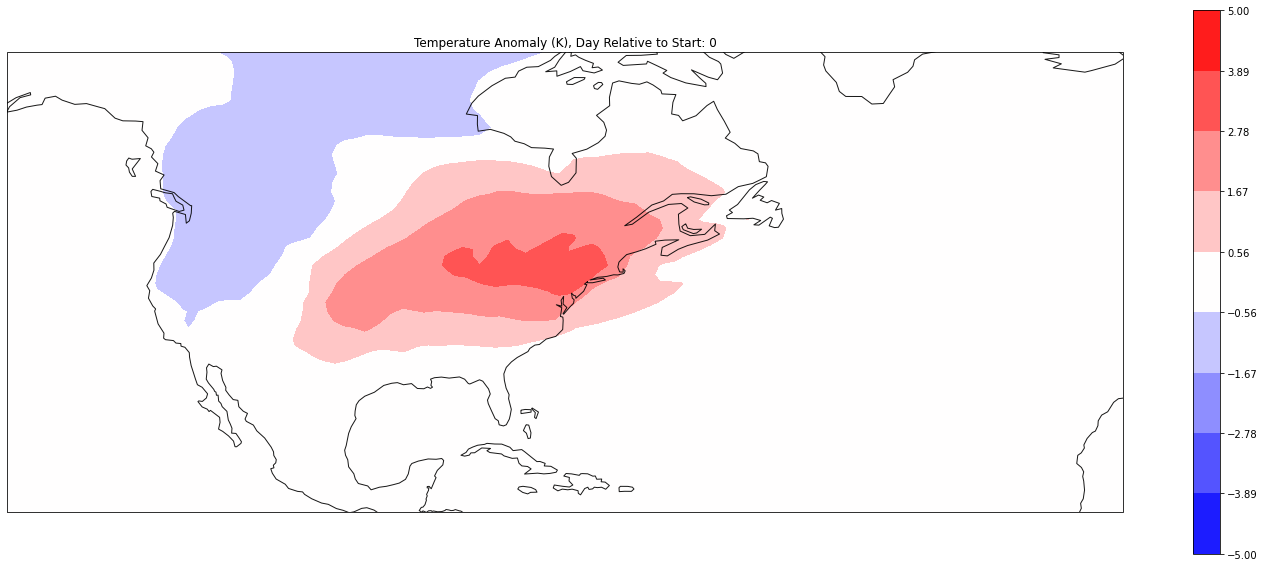

In [13]:
# Now plot the composite of temperature anomaly during the start date of events 
tcomp = anomrs[indices,:,:].mean(axis=0)


plotlims=[lonwant-60,lonwant+60,latwant-25,latwant+25]


# set temperature contours
tmax=5
tmin=-tmax
numcolors=10
tempcontoursf=np.linspace(tmin,tmax,numcolors)

counter=1
fig=plt.figure(figsize=(25,10))
#plot  composite 
ax = fig.add_subplot(1, 1, counter, projection=ccrs.EckertIII()) #1,1,1 a 1x1 subplot and the first entry
ax.set_global()
ax.coastlines('110m', alpha=0.9) #alpha is how dark lines are
plotto=ax.contourf(lon,lat,tcomp,transform=ccrs.PlateCarree(),cmap='bwr',levels=tempcontoursf)
fig.colorbar(plotto)
ax.set_extent(plotlims,crs=ccrs.PlateCarree())
plt.title("Temperature Anomaly (K), Day Relative to Start: " + str(0))
counter=counter+1


In [ ]:
# How does the temperature anomaly composite in AM4 compare to ERA5?

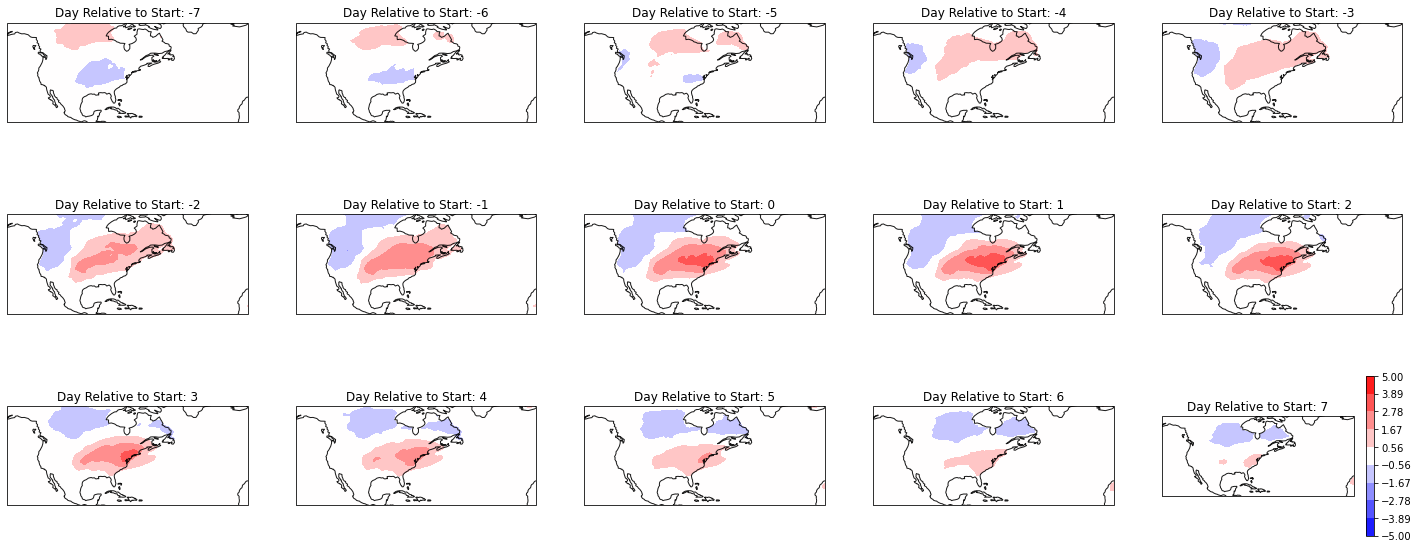

In [14]:
# Let's check out the time evolution of temperature anomaly for events in AM4. How does it compare to ERA5?
counter=1 #start a figure counter 
fig=plt.figure(figsize=(25,10)) #specify the figure size
for t in range(-7,8): # start a loop that will go from -7 days before the start dates to +7 after

    # composite relative to the start date, 0 is on the start dates, -1 is 1 day before +1 is 1 day after
    comp = anomrs[indices + t,:,:].mean(axis=0)


    #plot  composite 
    ax = fig.add_subplot(3, 5, counter, projection=ccrs.EckertIII()) # specifying a subplot with 3 rows and 5 columns
    ax.set_global()
    ax.coastlines('110m', alpha=0.9) #alpha is how dark lines are
    plotto=ax.contourf(lon,lat,comp,transform=ccrs.PlateCarree(),cmap='bwr',levels=tempcontoursf)
    #fig.colorbar(plotto)
    ax.set_extent(plotlims,crs=ccrs.PlateCarree())
    plt.title("Day Relative to Start: " + str(t))
    counter=counter+1 # increase the fig counter by 1 each time you go through the loop
    
fig.colorbar(plotto)


In [ ]:
# Now let's do geopotential height anomalies. First load in the Z500 data

directoryz = '/work/Veeshan.Narinesingh/EXTREME_HEAT_EVENTS_TdT_ANALYSIS/' + runname + '/ATMOS_CMIP/DAILY/' #directory for temp, psl, and zg data
filenamez = 'atmos_cmip.*.zg.0500hPa.daily.nc'
dsz = xr.open_mfdataset(directoryz + filenamez) 
varz = dsz.zg

varzsmooth5=varz.rolling(time=5,center=True,min_periods=1).mean()#5 day smooth using running mean
varzsmooth5np=varzsmooth5.values.reshape((50,365,180,288))
varzsmooth5rs= xr.DataArray(data=varzsmooth5np,dims=["year","day","lat","lon"],coords=dict(year=np.arange(2,52,1),day=np.arange(1,366,1)))
varzsmooth5rs15day1=varzsmooth5rs.rolling(day=15,center=True,min_periods=1).mean()#1st 15 day running mean 
varzsmooth5rs15day2=varzsmooth5rs15day1.rolling(day=15,center=True,min_periods=1).mean()#2nd 15 day running mean
climz=varzsmooth5rs15day2.rolling(year=11,center=True,min_periods=1).mean()#29 day by 11 year climatology
anomz=varzsmooth5rs-climz

# reshape the array back to days,lat,lon from years,days,lat,lon
zlon=varz.lon.values
zlat=varz.lat.values
anomrsz= anomz.values.reshape(nyrs * 365, len(zlat), len(zlon))


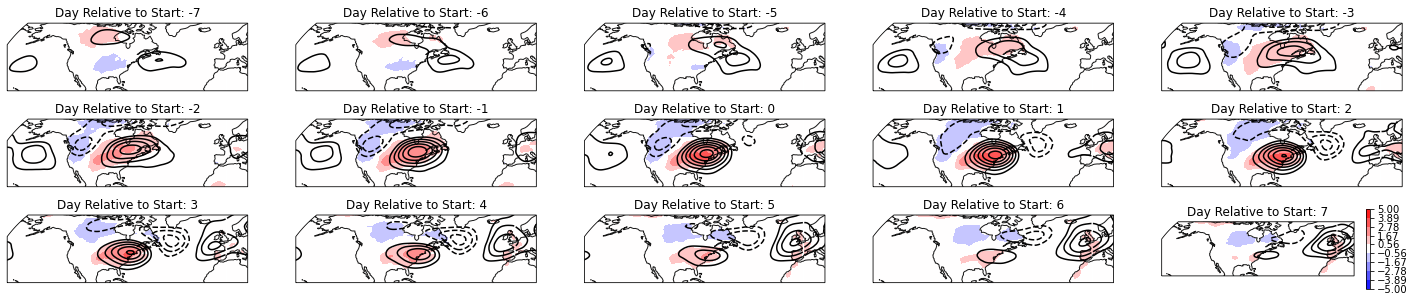

In [24]:
# Plot the Geopotential Height Anomalies. How does this compare to ERA5?

#Here's code to get composites of geopotential height from 7 days before to 7 days after
counter=1
zglvlspos=np.arange(10,150,10)
zglvlsneg=np.arange(-150,-10,10)

fig=plt.figure(figsize=(25,5))
for t in range(-7,8):

    # composite relative to the start date, 0 is on the start dates, -1 is 1 day before +1 is 1 day after
    comp = anomrsz[indices + t,:,:].mean(axis=0)
    compt = anomrs[indices + t,:,:].mean(axis=0)


    #plot  composite 
    ax = fig.add_subplot(3, 5, counter, projection=ccrs.EckertIII()) #1,1,1 a 1x1 subplot and the first entry
    ax.set_global()
    ax.coastlines('110m', alpha=0.9) #alpha is how dark lines are
    plottopos=ax.contour(zlon,zlat,comp,transform=ccrs.PlateCarree(),levels=zglvlspos,linestyles='solid',colors='black')
    plottoneg=ax.contour(zlon,zlat,comp,transform=ccrs.PlateCarree(),levels=zglvlsneg,linestyles='dashed',colors='black')
    plotto2=ax.contourf(lon,lat,compt,transform=ccrs.PlateCarree(),cmap='bwr',levels=tempcontoursf)
    ax.set_extent([lonwant-90,lonwant+90,20,70],crs=ccrs.PlateCarree())
    plt.title("Day Relative to Start: " + str(t))
    counter=counter+1
fig.colorbar(plotto2)
